In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
funding_rounds_df = pd.read_csv('/content/drive/MyDrive/Series A-nalysts/archive/funding_rounds.csv')
objects_df = pd.read_csv('/content/drive/MyDrive/Series A-nalysts/archive/objects.csv')

<ipython-input-19-35a9b52b15c3>:4: DtypeWarning: Columns (3,7,9,10,17,18,21,22,23,25,26,29,30,37) have mixed types. Specify dtype option on import or set low_memory=False.
  objects_df = pd.read_csv('/content/drive/MyDrive/Series A-nalysts/archive/objects.csv')


###Now we merge the objects_df which has all the companies' information and funding_rounds_df which has the information for funding rounds for each company into one dataframe

In [ ]:
full_df = pd.merge(objects_df, funding_rounds_df, left_on="id", right_on="object_id", how="inner")

### This is a simplification of our data and we can quickly see what to expect from our data.

In [ ]:
full_df_simplified = full_df[['id_x',  'founded_at', 'funding_rounds', 'funded_at', 'raised_amount_usd',  'is_last_round']]

###Here we fill na fields with the median and convert dates to datetime format. We also add columns such as company age at funding which is a numerical value. This allows our models to analyze the datetime information.

In [ ]:
# Sort the data
full_df_simplified = full_df_simplified.sort_values(by=['id_x', 'funded_at'])
full_df_simplified = full_df_simplified[full_df_simplified['raised_amount_usd'] < 40000000]

# Calculate cumulative sum of raised_amount_usd and current number of funding rounds
full_df_simplified['total_funding_until_this_point'] = full_df_simplified.groupby('id_x')['raised_amount_usd'].cumsum()
full_df_simplified['current_number_of_funding_rounds'] = full_df_simplified.groupby('id_x').cumcount() + 1

# Convert dates to datetime and create time features
full_df_simplified['founded_at'] = pd.to_datetime(full_df_simplified['founded_at'])
full_df_simplified['funded_at'] = pd.to_datetime(full_df_simplified['funded_at'])
full_df_simplified['company_age_at_funding'] = (full_df_simplified['funded_at'] - full_df_simplified['founded_at']).dt.days
full_df_simplified['time_since_last_round'] = full_df_simplified.groupby('id_x')['funded_at'].diff().dt.days.fillna(0)

# Shift target variable and drop rows where target is NaN
full_df_simplified['next_round_raised_amount_usd'] = full_df_simplified.groupby('id_x')['raised_amount_usd'].shift(-1)
full_df_simplified = full_df_simplified.dropna(subset=['next_round_raised_amount_usd'])

###Drop columns that have really low correlations or aren't used for prediction or that we repurposed into new columns

In [ ]:
full_df_simplified.drop(columns=[ 'is_last_round', 'founded_at', 'funded_at'], inplace=True)

<ipython-input-23-923ce55bf106>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df_simplified.drop(columns=[ 'is_last_round', 'founded_at', 'funded_at'], inplace=True)


###Scale numerical columns

In [ ]:
# Columns to scale
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

numerical_cols = ['raised_amount_usd', 'total_funding_until_this_point', 'company_age_at_funding', 'time_since_last_round']

# Standardizing these columns
scaler = StandardScaler()
full_df_simplified[numerical_cols] = scaler.fit_transform(full_df_simplified[numerical_cols])

# Fill missing values with the median
full_df_simplified = full_df_simplified.fillna(full_df_simplified.median())


<ipython-input-24-2cba50ed2c55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df_simplified[numerical_cols] = scaler.fit_transform(full_df_simplified[numerical_cols])
<ipython-input-24-2cba50ed2c55>:13: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  full_df_simplified = full_df_simplified.fillna(full_df_simplified.median())


###Filtering of data on round raised amount

In [ ]:
full_df_simplified = full_df_simplified[full_df_simplified['current_number_of_funding_rounds'] < 4]

full_df_simplified_less = full_df_simplified[full_df_simplified['next_round_raised_amount_usd'] < 20000000]
full_df_simplified_more = full_df_simplified[full_df_simplified['next_round_raised_amount_usd'] >= 20000000]

---



---

# END OF DATA PREPROCESSING

---



---



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import pandas as pd

full_df_simplified = full_df_simplified[full_df_simplified['current_number_of_funding_rounds'] < 4]

# Defining the target variable and features
X = full_df_simplified.drop(['next_round_raised_amount_usd', 'id_x'], axis=1)
y = full_df_simplified['next_round_raised_amount_usd']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=2/9, random_state=42)

# Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train, y_train)
y_test_pred_dt = dt_regressor.predict(X_test)

# Calculate MSE and RMSE for Decision Tree
test_mse_dt = mean_squared_error(y_test, y_test_pred_dt)
print(f"Test MSE for Decision Tree model: {test_mse_dt}")
print(f"RMSE for Decision Tree model: {np.sqrt(test_mse_dt)}")


Test MSE for Decision Tree model: 81010383805777.3
RMSE for Decision Tree model: 9000576.859611683


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_dt))
# rmse = np.sqrt(mean_squared_error(y_test_large, y_pred_large))

print(f"RMSE: {rmse}")


RMSE: 9000576.859611683


In [ ]:
residuals = abs(y_test - y_test_pred_dt)
residuals.describe()
#residuals.hist(bins=15)

count    3.577000e+03
mean     5.822861e+06
std      6.864244e+06
min      0.000000e+00
25%      9.910000e+05
50%      3.220000e+06
75%      8.200000e+06
max      3.792500e+07
Name: next_round_raised_amount_usd, dtype: float64

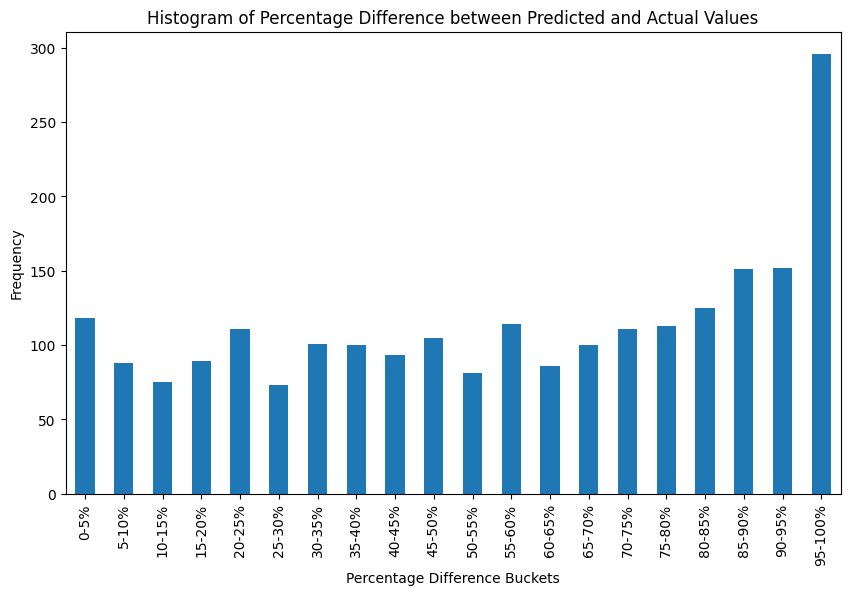

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the percentage difference
percentage_diff = abs((y_test - y_test_pred_dt) / y_test) * 100

# Categorize into buckets
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
labels = ['0-5%', '5-10%', '10-15%', '15-20%', '20-25%', '25-30%', '30-35%', '35-40%', '40-45%', '45-50%', '50-55%', '55-60%', '60-65%', '65-70%', '70-75%', '75-80%', '80-85%', '85-90%', '90-95%', '95-100%']
percentage_diff_binned = pd.cut(percentage_diff, bins=bins, labels=labels, include_lowest=True)

# Plot histogram
plt.figure(figsize=(10,6))
percentage_diff_binned.value_counts(sort=False).plot(kind='bar')
plt.xlabel('Percentage Difference Buckets')
plt.ylabel('Frequency')
plt.title('Histogram of Percentage Difference between Predicted and Actual Values')
plt.show()

<Axes: >

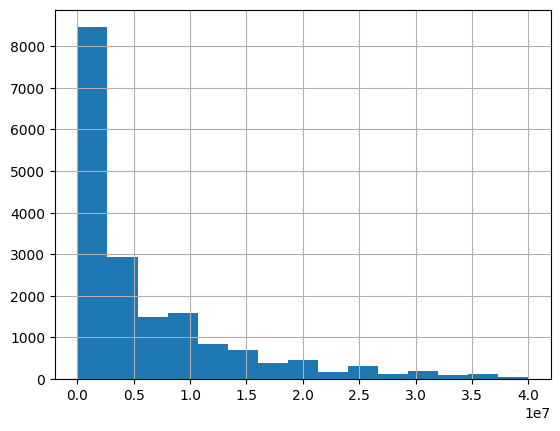

In [ ]:
full_df_simplified.describe()
full_df_simplified['next_round_raised_amount_usd'].hist(bins=15)